In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os




np.float64(2.0)

In [ ]:

def get_dataset(data_path):
  result = []
  files_counter = 0
  for file in os.listdir(data_path):
    f_path = os.path.join(data_path , file)
    result.append(f_path)
    files_counter+=1

  print("Files: "+str(files_counter))
  return result



mask_path = "../assets/datasets/DeepCrack/train_lab"
imgs_path = "../assets/datasets/DeepCrack/train_img"


dataset_img = get_dataset(imgs_path)
dataset_mask = get_dataset(mask_path)


class DeepCrackDataSet(Dataset):
  def __init__(self, img_dir, mask_dir, transform=None):
  
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.transform = transform

    self.images = sorted([os.path.join(img_dir, file) for file in os.listdir(img_dir)] )
    self.masks = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir)]) 


  def __len__(self):
    return len(self.images)


  def __getitem__(self, idx):

    np_image = np.array(Image.open(self.images[idx]))
    np_mask = np.array(Image.open(self.masks[idx])) 

   
    if len(np_mask.shape) == 3:
      np_mask = np_mask[:,:,0]

    np_mask = (np_mask > 127).astype(np.uint8)
    
    if self.transform: # if using transforms
      t = self.transform(image=np_image, mask=np_mask)
      np_image = t["image"]
      np_mask = t["mask"]


    tensor_image = torch.from_numpy(np_image).permute(2, 0, 1).float() / 255.0
    tensor_mask = torch.from_numpy(np_mask).unsqueeze(0).float() 

    return tensor_image,tensor_mask
  
  
  

Files: 300
Files: 300


In [ ]:

dataset = DeepCrackDataSet(
  imgs_path,
  mask_path
)

train_set_len, test_set_len, val_set_len = int(dataset.__len__() * 0.8), int(dataset.__len__() * 0.1) , int(dataset.__len__() * 0.1)
train_set, test_set ,val_set = random_split(dataset, [train_set_len, test_set_len, val_set_len])

train_loader = DataLoader( train_set, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader( test_set, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
val_loader = DataLoader( val_set, batch_size=32 , shuffle=False, num_workers=4, pin_memory=True)



In [246]:
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Val batches: {len(val_loader)}")


Train batches: 8
Test batches: 1
Val batches: 1


In [247]:

for images, masks in train_loader:
    print(f"Image batch shape: {images.shape}")  
    print(f"Mask batch shape: {masks.shape}")    
    print(f"Image range: [{images.min():.2f}, {images.max():.2f}]")
    print(f"Mask unique values: {masks.unique()}")
    break  



Image batch shape: torch.Size([32, 3, 384, 544])
Mask batch shape: torch.Size([32, 1, 384, 544])
Image range: [0.00, 1.00]
Mask unique values: tensor([0., 1.])


In [248]:
import matplotlib.pyplot as plt

def plot_data(train_loader, batches=8):
    counter = 0
    # Wczytaj jeden batch
    for images, masks in train_loader:
        # Weź pierwsze 4 przykłady z batcha
        fig, axes = plt.subplots(4, 2, figsize=(8, 12))
        
        for i in range(4):
            # Obraz
            img = images[i].permute(1, 2, 0).numpy()  
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f"Image {i+1}")
            axes[i, 0].axis('off')
            
            # # Maska
            mask = masks[i, 0].numpy()  
            # axes[i, 1].imshow(mask, cmap='gray')
            # axes[i, 1].set_title(f"Mask {i+1}")
            # axes[i, 1].axis('off')
            
            # Overlay (obraz + maska)
            axes[i, 1].imshow(img)
            axes[i, 1].imshow(mask, cmap='Reds', alpha=0.5) 
            axes[i, 1].set_title(f"Overlay {i+1}")
            axes[i, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
        counter+=1
        if counter == batches:
            break  # Tylko jeden batch

In [ ]:
import albumentations as A


train_transform = A.Compose([
    A.RandomResizedCrop(size=(256,256),scale=(0.5, 1.0)),
    A.HorizontalFlip(p=0.5),  
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
], seed=np.random.randint(low=1, high=1000))


In [250]:

dataset = DeepCrackDataSet(
  imgs_path,
  mask_path,
  transform=train_transform
)

train_set_len, test_set_len, val_set_len = int(dataset.__len__() * 0.8), int(dataset.__len__() * 0.1) , int(dataset.__len__() * 0.1)
train_set, test_set ,val_set = random_split(dataset, [train_set_len, test_set_len, val_set_len])

train_loader = DataLoader( train_set, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader( test_set, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
val_loader = DataLoader( val_set, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)



# plot_data(train_loader,5)


In [251]:
import segmentation_models_pytorch as smp

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')


In [252]:
model = smp.Unet(
  encoder_name="resnet34",
  encoder_weights="imagenet",
  in_channels=3,
  classes=1,
  activation=None,
)

model = model.to(device)

In [253]:

# Policz parametry
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n Model size:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB")


 Model size:
   Total parameters: 24,436,369
   Trainable parameters: 24,436,369
   Model size: ~97.7 MB


In [254]:
for images, masks in train_loader:
  images = images.to(device)
  masks = masks.to(device)

  print(f"Input shape: {images.shape}")   # [8, 3, 256, 256]
  print(f"Target shape: {masks.shape}")   # [8, 1, 256, 256]
    

  with torch.no_grad():
    predictions = model(images)

  print(f"Output shape: {predictions.shape}")  # [8, 1, 256, 256]
  print(f"Output range: [{predictions.min():.3f}, {predictions.max():.3f}]")
  break
    

Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16, 1, 256, 256])
Output shape: torch.Size([16, 1, 256, 256])
Output range: [-4.291, 7.331]


In [255]:
class DiceLoss(torch.nn.Module):
  def __init__(self, smooth=1e-6):
    super(DiceLoss,self).__init__()
    self.smooth = smooth
  def forward(self, predictions, targets):
    predictions = torch.sigmoid(predictions)

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    dice = (2. * intersection  + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

    return 1-dice

In [256]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(
  model.parameters(),
  lr=1e-4,
  weight_decay=1e-5
)
print("✅ Optimizer created!")
print(f"   Type: Adam")
print(f"   Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"   Weight decay: {optimizer.param_groups[0]['weight_decay']}")

✅ Optimizer created!
   Type: Adam
   Learning rate: 0.0001
   Weight decay: 1e-05


In [257]:
# 1 batch training

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = .0

    for batch_idx, (images, masks) in enumerate(train_loader):
        # Przenieś na GPU
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        predictions = model(images)
        loss = criterion(predictions, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    avg_loss = running_loss / len(train_loader)
    return avg_loss

In [258]:
import gc
torch.cuda.empty_cache()
gc.collect()


85

In [259]:
def validate(model, val_loader, criterion,device):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images,masks in val_loader:
      images = images.to(device)
      masks = masks.to(device)

      predictions = model(images)
      loss = criterion(predictions, masks)

      running_loss += loss.item()
  
  avg_loss = running_loss / len(val_loader)
  return avg_loss

In [263]:
import time

epochs = 20
best_val_loss = float('inf')
for epoch in range(epochs):
  print("=" * 60)
  print(f"EPOCH {epoch + 1}/{epochs}")
  print("=" * 60)

  epoch_start = time.time()

  train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
  val_loss = validate(model, val_loader, criterion, device)

  epoch_time = time.time() - epoch_start
  print("\n" + "-" * 60)
  print(f"Epoch {epoch + 1} Summary:")
  print(f"  Train Loss: {train_loss:.4f}")
  print(f"  Val Loss:   {val_loss:.4f}")
  print(f"  Time:       {epoch_time:.1f}s (~{epoch_time/60:.1f} min)")
  print("-" * 60)  

  if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"✅ New best model! (Val Loss: {val_loss:.4f})")


print("=" * 60)
print("✅ TRAINING COMPLETED!")
print("=" * 60)
print(f"Best Val Loss: {best_val_loss:.4f}")



EPOCH 1/20
  Batch [10/15], Loss: 0.8804

------------------------------------------------------------
Epoch 1 Summary:
  Train Loss: 0.8805
  Val Loss:   0.8861
  Time:       163.5s (~2.7 min)
------------------------------------------------------------
✅ New best model! (Val Loss: 0.8861)
EPOCH 2/20
  Batch [10/15], Loss: 0.8474

------------------------------------------------------------
Epoch 2 Summary:
  Train Loss: 0.8721
  Val Loss:   0.8737
  Time:       154.7s (~2.6 min)
------------------------------------------------------------
✅ New best model! (Val Loss: 0.8737)
EPOCH 3/20
  Batch [10/15], Loss: 0.8761

------------------------------------------------------------
Epoch 3 Summary:
  Train Loss: 0.8650
  Val Loss:   0.8602
  Time:       152.5s (~2.5 min)
------------------------------------------------------------
✅ New best model! (Val Loss: 0.8602)
EPOCH 4/20
  Batch [10/15], Loss: 0.8156

------------------------------------------------------------
Epoch 4 Summary:
  Tr

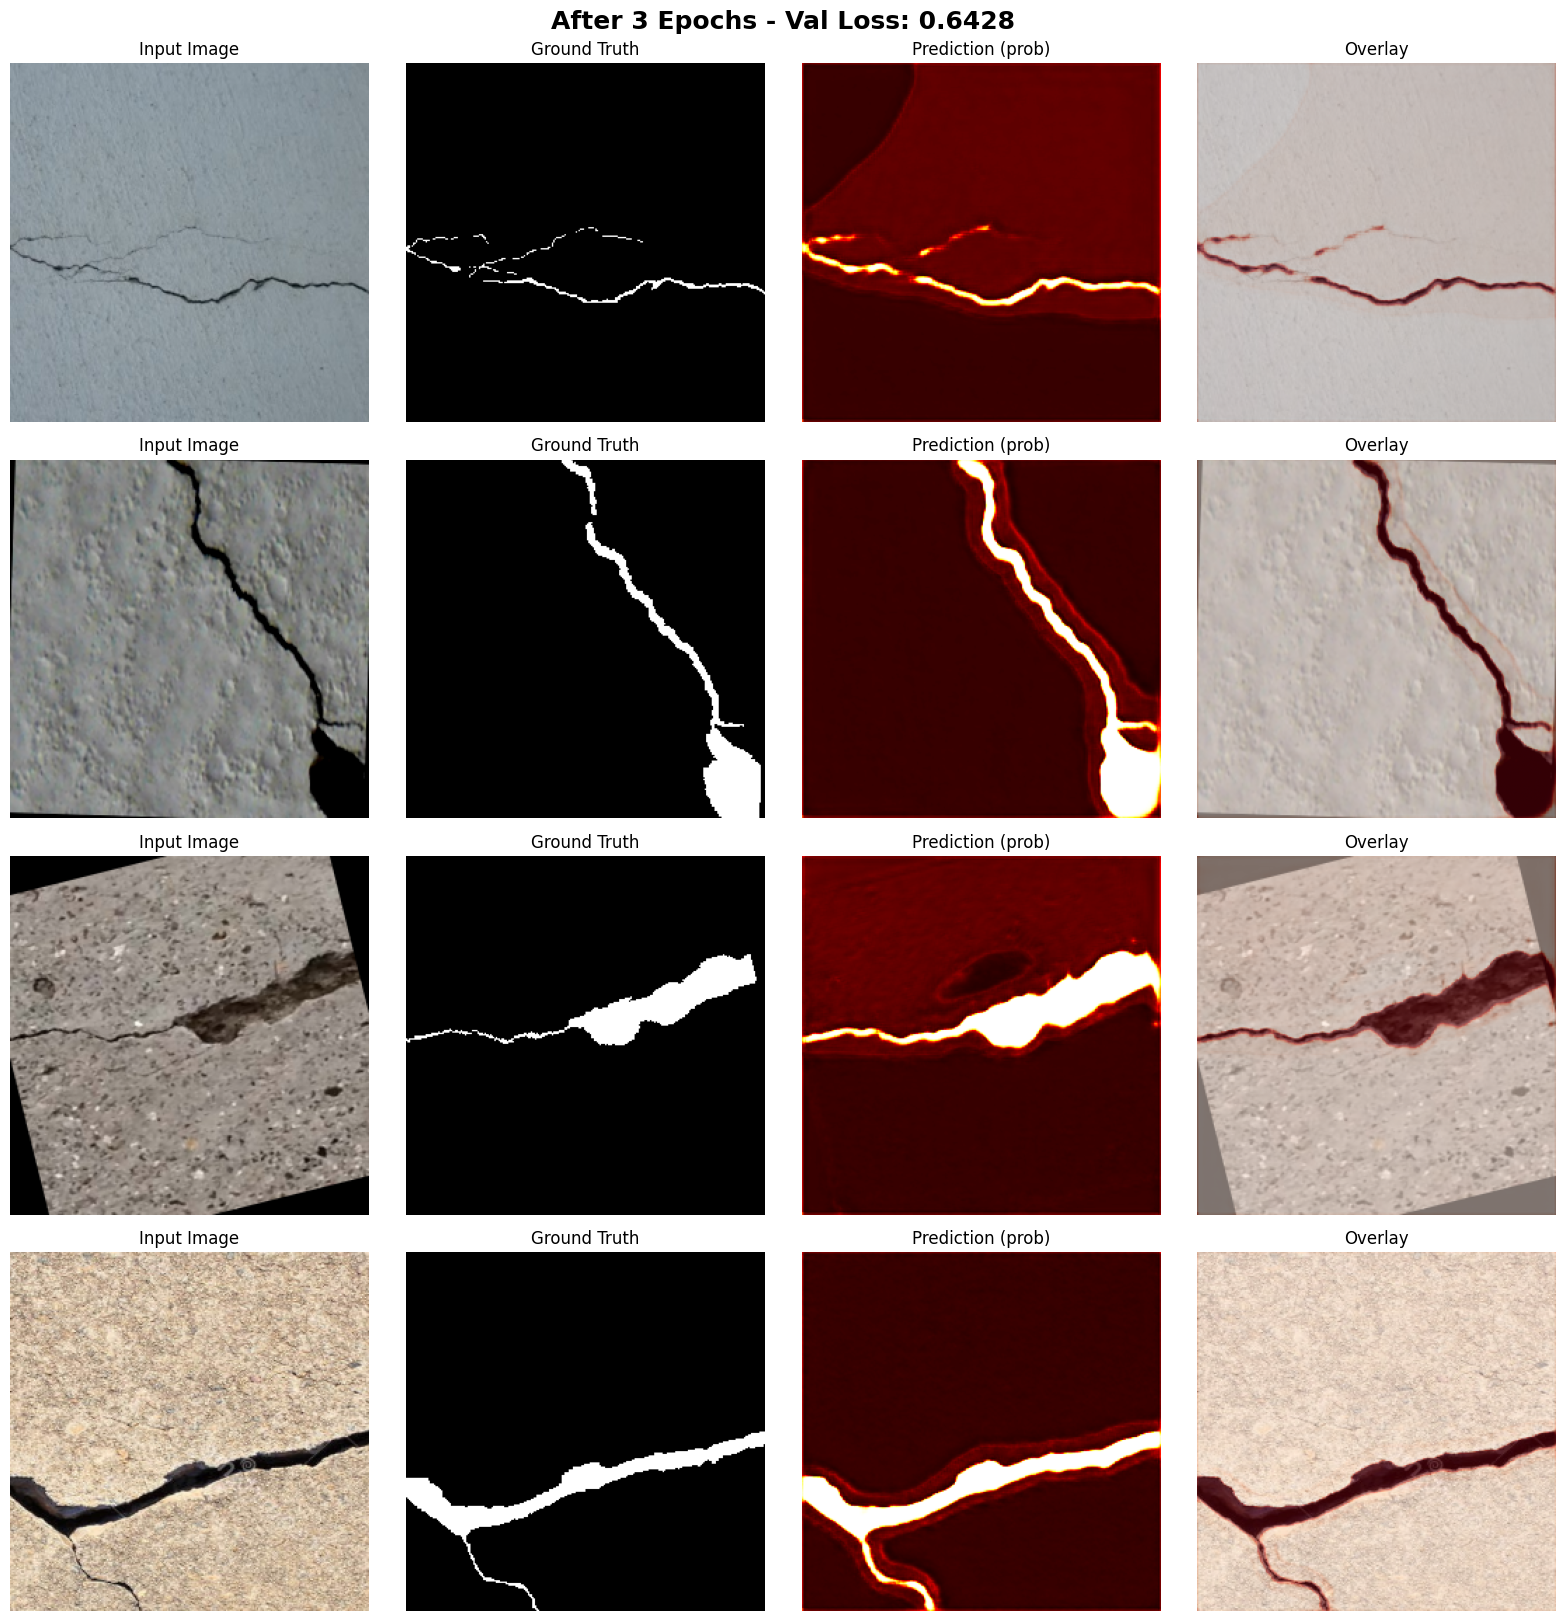

🔍 Check:
  - Are predictions detecting cracks? (even roughly)
  - Red areas should align with actual cracks
  - It's OK if predictions are weak/blurry at this stage!


In [264]:
import matplotlib.pyplot as plt

# Ewaluacja
model.eval()

for images, masks in test_loader:
    images = images.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        predictions = model(images)
        predictions = torch.sigmoid(predictions)  # Logits → probabilities
    
    # Wizualizuj pierwsze 4 przykłady
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    
    for i in range(4):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        mask_true = masks[i, 0].cpu().numpy()
        mask_pred = predictions[i, 0].cpu().numpy()
        
        # Obraz
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Input Image", fontsize=12)
        axes[i, 0].axis('off')
        
        # Prawdziwa maska
        axes[i, 1].imshow(mask_true, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title("Ground Truth", fontsize=12)
        axes[i, 1].axis('off')
        
        # Predykcja (heatmap)
        axes[i, 2].imshow(mask_pred, cmap='hot', vmin=0, vmax=1)
        axes[i, 2].set_title("Prediction (prob)", fontsize=12)
        axes[i, 2].axis('off')
        
        # Overlay
        axes[i, 3].imshow(img)
        axes[i, 3].imshow(mask_pred, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
        axes[i, 3].set_title("Overlay", fontsize=12)
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"After 3 Epochs - Val Loss: {best_val_loss:.4f}", 
                 fontsize=18, y=1.01, fontweight='bold')
    plt.show()
    break

print("🔍 Check:")
print("  - Are predictions detecting cracks? (even roughly)")
print("  - Red areas should align with actual cracks")
print("  - It's OK if predictions are weak/blurry at this stage!")

In [265]:
import os

# Utwórz folder na modele (jeśli nie istnieje)
os.makedirs("../models", exist_ok=True)

# Zapisz checkpoint
torch.save({
    'epoch': 3,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': 0.8946,
    'val_loss': best_val_loss,
}, '../models/unet_epoch3.pth')

print(f"✅ Model saved: ../models/unet_epoch3.pth")
print(f"   Val Loss: {best_val_loss:.4f}")

✅ Model saved: ../models/unet_epoch3.pth
   Val Loss: 0.6428


In [ ]:
from tqdm import tqdm



def evaluate_model(model, dataloader, device, threshold=0.5):
    """
    Kompletna ewaluacja modelu
    
    Returns:
        metrics: dict z metrykami
        predictions: array predykcji [N, H, W]
        ground_truths: array prawdziwych masek [N, H, W]
    """
    model.eval()
    
    all_predictions = []
    all_ground_truths = []
    
    print("🔍 Running evaluation...")
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Processing batches"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            predictions = torch.sigmoid(outputs)
            
            # Do CPU
            all_predictions.append(predictions.cpu().numpy())
            all_ground_truths.append(masks.cpu().numpy())
    
    # Concatenate
    predictions = np.concatenate(all_predictions, axis=0)[:, 0]  # [N, H, W]
    ground_truths = np.concatenate(all_ground_truths, axis=0)[:, 0]  # [N, H, W]
    
    # Binaryzacja
    pred_binary = (predictions > threshold).astype(np.float32)
    gt_binary = (ground_truths > 0.5).astype(np.float32)
    
    # ========================================
    # OBLICZ METRYKI
    # ========================================
    ious = []
    precisions = []
    recalls = []
    f1_scores = []
    accuracies = []
    
    for pred, gt in zip(pred_binary, gt_binary):
        # Confusion matrix
        tp = (pred * gt).sum()
        fp = (pred * (1 - gt)).sum()
        fn = ((1 - pred) * gt).sum()
        tn = ((1 - pred) * (1 - gt)).sum()
        
        # IoU (Intersection over Union)
        iou = tp / (tp + fp + fn + 1e-6)
        ious.append(iou)
        
        # Precision (jakość detekcji)
        precision = tp / (tp + fp + 1e-6)
        precisions.append(precision)
        
        # Recall (czułość)
        recall = tp / (tp + fn + 1e-6)
        recalls.append(recall)
        
        # F1 Score (harmonic mean)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        f1_scores.append(f1)
        
        # Accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)
        accuracies.append(accuracy)
    
    metrics = {
        'iou_mean': np.mean(ious),
        'iou_std': np.std(ious),
        'iou_median': np.median(ious),
        'precision_mean': np.mean(precisions),
        'precision_std': np.std(precisions),
        'recall_mean': np.mean(recalls),
        'recall_std': np.std(recalls),
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'accuracy_mean': np.mean(accuracies),
        'ious': ious,
        'precisions': precisions,
        'recalls': recalls,
        'f1_scores': f1_scores,
    }
    
    return metrics, predictions, ground_truths

# ========================================
# UŻYCIE
# ========================================
# Potrzebujesz test_loader - jeśli nie masz, użyj val_loader
metrics, predictions, ground_truths = evaluate_model(model, test_loader, device, threshold=0.5)

NameError: name 'model' is not defined

/tmp/ipykernel_16570/2226347563.py:60: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16570/2226347563.py:60: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


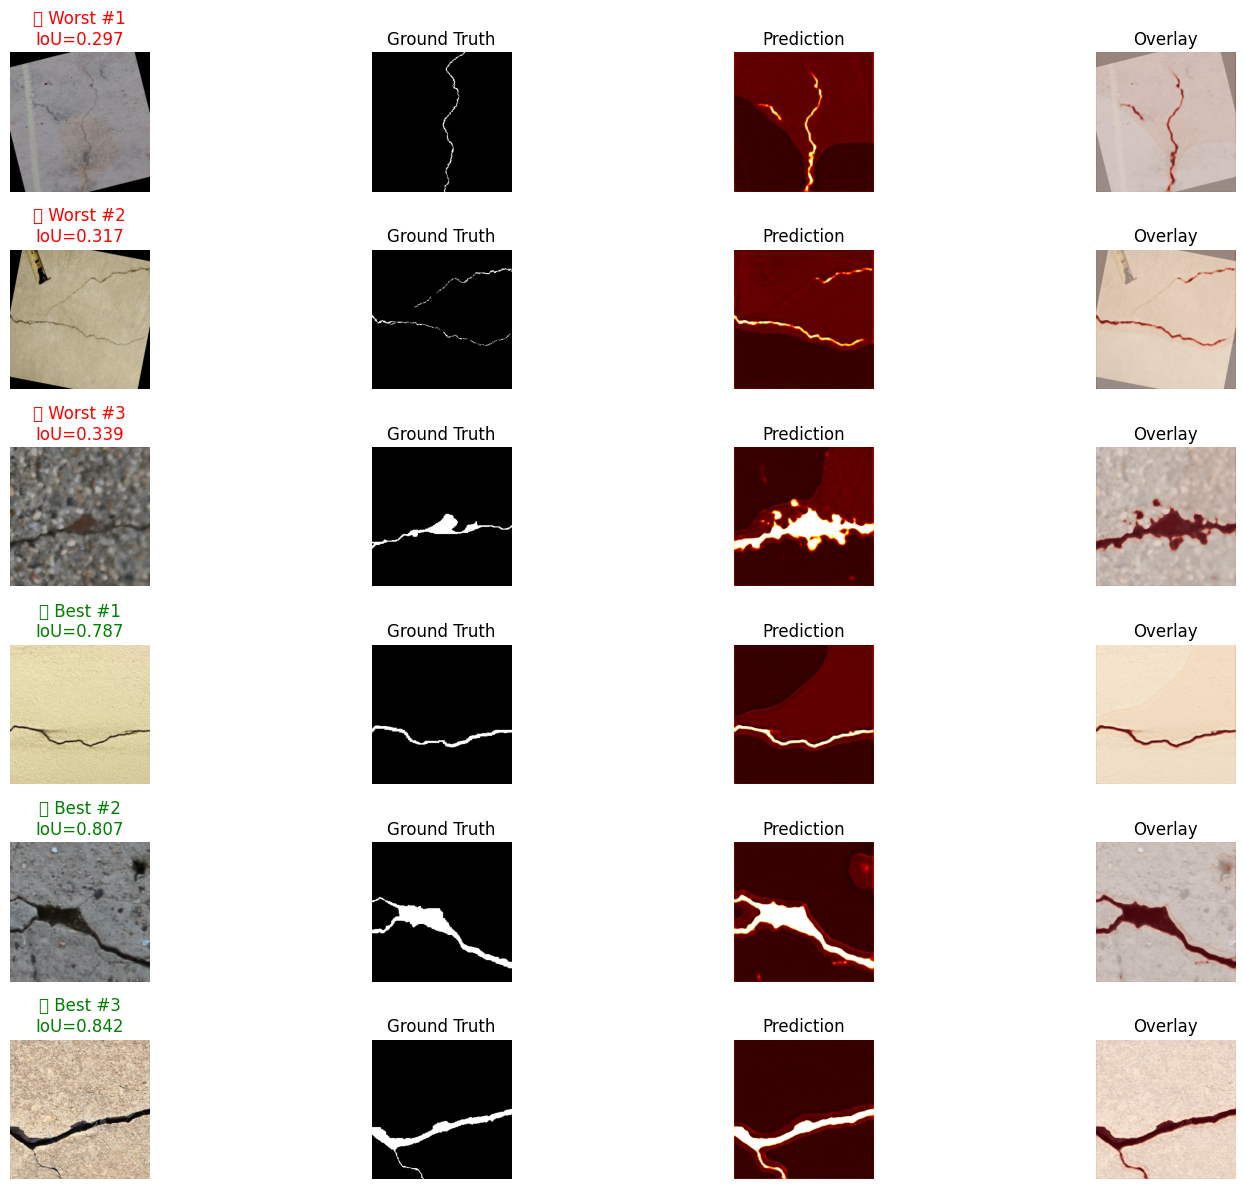

✅ Saved: ../results/best_worst_predictions.png


In [270]:
def visualize_best_worst(predictions, ground_truths, test_loader, metrics, n=3):
    """Wizualizuj best i worst predictions"""
    # Sortuj według IoU
    sorted_indices = np.argsort(metrics['ious'])
    worst_indices = sorted_indices[:n]
    best_indices = sorted_indices[-n:]
    
    # Pobierz obrazy
    all_images = []
    for images, _ in test_loader:
        all_images.extend(images.numpy())
    all_images = np.array(all_images)
    
    # Plot
    fig, axes = plt.subplots(2*n, 4, figsize=(16, 4*n))
    
    # WORST
    for i, idx in enumerate(worst_indices):
        img = all_images[idx].transpose(1, 2, 0)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"❌ Worst #{i+1}\nIoU={metrics['ious'][idx]:.3f}", fontsize=12, color='red')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(ground_truths[idx], cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title("Ground Truth", fontsize=12)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(predictions[idx], cmap='hot', vmin=0, vmax=1)
        axes[i, 2].set_title("Prediction", fontsize=12)
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(img)
        axes[i, 3].imshow(predictions[idx], cmap='Reds', alpha=0.6, vmin=0, vmax=1)
        axes[i, 3].set_title("Overlay", fontsize=12)
        axes[i, 3].axis('off')
    
    # BEST
    for i, idx in enumerate(best_indices):
        row = n + i
        img = all_images[idx].transpose(1, 2, 0)
        
        axes[row, 0].imshow(img)
        axes[row, 0].set_title(f"✅ Best #{i+1}\nIoU={metrics['ious'][idx]:.3f}", fontsize=12, color='green')
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(ground_truths[idx], cmap='gray', vmin=0, vmax=1)
        axes[row, 1].set_title("Ground Truth", fontsize=12)
        axes[row, 1].axis('off')
        
        axes[row, 2].imshow(predictions[idx], cmap='hot', vmin=0, vmax=1)
        axes[row, 2].set_title("Prediction", fontsize=12)
        axes[row, 2].axis('off')
        
        axes[row, 3].imshow(img)
        axes[row, 3].imshow(predictions[idx], cmap='Reds', alpha=0.6, vmin=0, vmax=1)
        axes[row, 3].set_title("Overlay", fontsize=12)
        axes[row, 3].axis('off')
    
    plt.tight_layout()
    # plt.savefig('../results/best_worst_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Saved: ../results/best_worst_predictions.png")

# UŻYCIE
visualize_best_worst(predictions, ground_truths, test_loader, metrics, n=3)